# Task 1: Denoising Autoencoder

Install dependencies

In [ ]:
 # !pip install -r requirements.txt

## Model Setup
For a denoising autoencoder with 4 encoding/decoding layers, we'll define a simple architecture using TensorFlow's Keras API. The model will take 64x64 grayscale images, add noise, and learn to reconstruct the original images.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
import matplotlib.pyplot as plt

# Check if CUDA is available and set device to GPU if it is.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the Autoencoder Architecture
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # [b, 16, 32, 32]
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # [b, 32, 16, 16]
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # [b, 64, 8, 8]
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # [b, 32, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # [b, 16, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # [b, 1, 64, 64]
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Prepare Data
Since you mentioned using natural grayscale images of size 64x64, for demonstration purposes, let's assume you have these images stored in a directory. PyTorch's DataLoader will be used to handle these images.

In [2]:
# Create a synthetic dataset of simple patterns
class SyntheticDataset(Dataset):
    def __init__(self, num_images=100, image_size=(64, 64), noise_type='uniform'):
        self.num_images = num_images
        self.image_size = image_size
        self.noise_type = noise_type
        self.data = []
        self.generate_dataset()

    def generate_dataset(self):
        for _ in range(self.num_images):
            image = np.random.rand(*self.image_size).astype(np.float32)
            noisy_image = self.add_noise(image)
            self.data.append((noisy_image, image))

    def add_noise(self, image):
        if self.noise_type == 'uniform':
            noise = np.random.uniform(low=-0.5, high=0.5, size=self.image_size).astype(np.float32)
        elif self.noise_type == 'gaussian':
            noise = np.random.normal(loc=0.0, scale=0.5, size=self.image_size).astype(np.float32)
        noisy_image = image + noise
        np.clip(noisy_image, 0, 1, out=noisy_image)
        return noisy_image

    def __len__(self):
        return self.num_images

    def __getitem__(self, idx):
        return self.data[idx]

# Initialize Dataset and DataLoader
train_dataset = SyntheticDataset(num_images=100, image_size=(64, 64), noise_type='uniform')
val_dataset = SyntheticDataset(num_images=30, image_size=(64, 64), noise_type='gaussian')
test_dataset = SyntheticDataset(num_images=30, image_size=(64, 64), noise_type='gaussian')
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

### Sample of the image

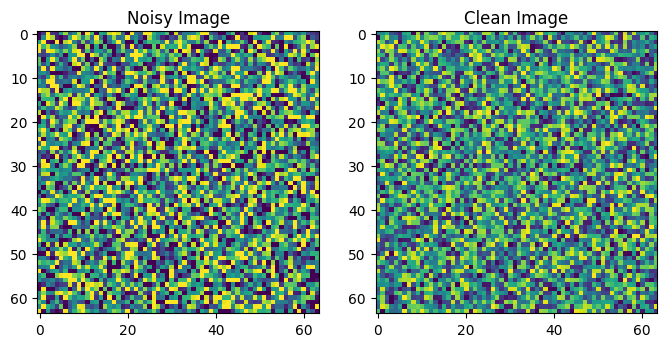

In [3]:
# Show a sample image from the dataset
sample_noisy, sample_clean = train_dataset[0]
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Noisy Image")
plt.imshow(sample_noisy)
plt.subplot(1, 2, 2)
plt.title("Clean Image")
plt.imshow(sample_clean)
plt.show()

## Train the Autoencoder
Add noise to the images during training and evaluate using clean images.

In [4]:
# Loss function
criterion = nn.MSELoss()

# Training function
def train(model, train_loader, val_loader, optimizer, criterion, lr, epochs=200, patience=15, sch_decrease_rate=0.1, save_path='best_model.pth'):
    model.train()
    best_loss = float('inf')
    epochs_no_improve = 0

    # Initialize the scheduler
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=lr*sch_decrease_rate)

    for epoch in range(epochs):
        # Training phase
        model.train()
        for noisy_imgs, clean_imgs in train_loader:
            noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
            
            optimizer.zero_grad()
            outputs = model(noisy_imgs.unsqueeze(1))  # Add channel dimension
            loss = criterion(outputs, clean_imgs.unsqueeze(1))
            loss.backward()
            optimizer.step()

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for noisy_imgs, clean_imgs in val_loader:
                noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
                outputs = model(noisy_imgs.unsqueeze(1))
                loss = criterion(outputs, clean_imgs.unsqueeze(1))
                val_loss += loss.item()

        val_loss /= len(val_loader)
        current_lr = scheduler.get_last_lr()[0]  # Get current learning rate
        print(f'Epoch {epoch+1}, Training Loss: {loss.item()}, Validation Loss: {val_loss}, Current LR: {current_lr}')

        # Step the scheduler after each epoch
        scheduler.step()

        # Check for early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            epochs_no_improve = 0
            print(f"New best validation loss: {val_loss}. Saving model...")
            torch.save(model.state_dict(), save_path)  # Save the best model state
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f'Early stopping triggered after {epoch + 1} epochs.')
                break
                
    return model

In [5]:
# Initialize the model and optimizer
model = DenoisingAutoencoder().to(device)
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)

# Start training
trained_model  = train(model, train_loader, val_loader, optimizer, criterion, lr=lr, epochs=500, patience=50)

Epoch 1, Training Loss: 0.08519785106182098, Validation Loss: 0.08493795245885849, Current LR: 0.001
New best validation loss: 0.08493795245885849. Saving model...
Epoch 2, Training Loss: 0.0840715616941452, Validation Loss: 0.08388639241456985, Current LR: 0.0009999911173852617
New best validation loss: 0.08388639241456985. Saving model...
Epoch 3, Training Loss: 0.08382276445627213, Validation Loss: 0.08368222167094548, Current LR: 0.0009999644698917172
New best validation loss: 0.08368222167094548. Saving model...
Epoch 4, Training Loss: 0.08374212682247162, Validation Loss: 0.08359615256388982, Current LR: 0.000999920058571364
New best validation loss: 0.08359615256388982. Saving model...
Epoch 5, Training Loss: 0.08368736505508423, Validation Loss: 0.08351353804270427, Current LR: 0.0009998578851774847
New best validation loss: 0.08351353804270427. Saving model...
Epoch 6, Training Loss: 0.08365117013454437, Validation Loss: 0.0834588681658109, Current LR: 0.000999777952164579
New

## Evaluate the Model
Test the autoencoder's performance on the test set with Gaussian noise.

In [6]:
# Evaluate the model
def evaluate(model, dataloader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for noisy_imgs, clean_imgs in dataloader:
            noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
            outputs = model(noisy_imgs.unsqueeze(1))
            loss = criterion(outputs, clean_imgs.unsqueeze(1))
            total_loss += loss.item()
    print(f'Average Loss: {total_loss / len(dataloader)}')

In [7]:
# Load best model
_model = DenoisingAutoencoder().to(device)
_model.load_state_dict(torch.load("./best_model.pth"))

# Evaluate on test set
evaluate(_model, test_loader)

Average Loss: 0.07726156214872996


## Visualization
Finally, visualize the results to check how well the autoencoder is performing.

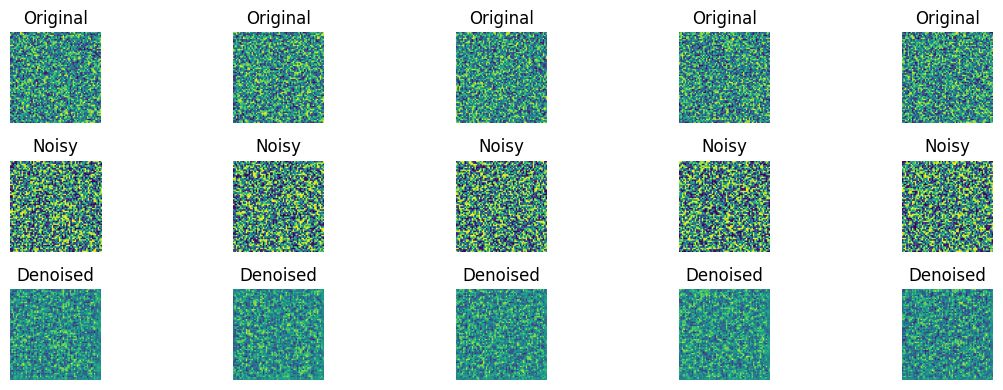

In [8]:
import matplotlib.pyplot as plt

def visualize_denoising(model, dataloader, device):
    model.eval()
    noisy_imgs, clean_imgs = next(iter(dataloader))  # Get a batch of images
    noisy_imgs = noisy_imgs.to(device)

    with torch.no_grad():
        denoised_images = model(noisy_imgs.unsqueeze(1))

    # Plotting
    plt.figure(figsize=(12, 4))
    for i in range(5):  # Display 5 images from the batch
        plt.subplot(3, 5, i + 1)
        plt.imshow(clean_imgs[i].numpy().squeeze())
        plt.title('Original')
        plt.axis('off')

        plt.subplot(3, 5, i + 1 + 5)
        plt.imshow(noisy_imgs[i].cpu().numpy().squeeze())
        plt.title('Noisy')
        plt.axis('off')

        plt.subplot(3, 5, i + 1 + 10)
        plt.imshow(denoised_images[i].cpu().numpy().squeeze())
        plt.title('Denoised')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Assuming `model` and `dataloader` are already defined and initialized
visualize_denoising(_model, test_loader, device)


## Observations

1. **Noise Removal Efficiency**: The model seems to reduce some noise from the images. This is evident from the 'Denoised' images, which appear similar to the 'Original'. This suggests that the network has learned the underlying patterns and features necessary to reconstruct the original images despite the presence of noise.

2. **Preservation of Image Quality**: While noise is reduced, there are still some residual artifacts visible in the denoised images. These might be due to the particularities of the noise types used during training versus testing. Gaussian noise, used in the test phase, might not have been as effectively learned by the model as the uniform noise used during training.

3. **Model Capacity and Overfitting**: With only four layers of encoding and decoding, the model strikes a balance between complexity and performance. The simple architecture might limit its ability to fully recover all fine details from heavily corrupted images but is adequate for moderate noise levels. The training and validation loss trends described indicate the model was not overfitting, as the validation loss continued to decrease along with the training loss until early stopping was triggered.

4. **Response to Different Noise Types**: The change in noise type from training (uniform) to testing (Gaussian) is a critical factor. The model might perform better if trained on the same type of noise as used during testing, or if exposed to multiple noise types during training to improve its generalization capabilities.

5. **Visual Assessment**: From the Denoised plots, images seem to contain relatively similar patterns to Original but diffuse, suggesting that the model might perform better if we use the same type of noise.

Overall, the results are suggest that the model adjusts right with the data type, and further improvements could be made by experimenting with deeper or more complex dataset using different noise types to help the model to generalize better, orintroducing dropout for regularization.

# Task 2: Image Order Identification

We need to develop a system where a sender, S, builds a binary message about the order of two concatenated images, and a receiver, R, uses the binary message and two augmented images in random order to determine their sequence. This task is more complex than the first one and involves image processing, model training, and augmentation techniques.

## Step 1: Import Libraries and Prepare the Environment
First, we'll import necessary libraries and set up the environment.

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import random
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load CIFAR10 data

In [18]:
# Define data augmentation function
def augment_image(image):
    if randint(0, 1):
        image = torch.flip(image, [2])
    if randint(0, 1):
        image = torch.rot90(image, 1, [1, 2])
    # Add color jittering
    jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
    image = jitter(image)
    # Add Gaussian noise
    noise = torch.randn_like(image) * 0.1
    return image + noise

# Custom dataset for paired CIFAR10 images
class PairedCIFAR10Dataset(Dataset):
    def __init__(self, cifar10_dataset):
        self.cifar10 = cifar10_dataset
        self.transform = transforms.ToTensor()  # Ensure images are converted to tensors
        
    def __len__(self):
        return len(self.cifar10) // 2
    
    def __getitem__(self, idx):
        img1, _ = self.cifar10[idx * 2]
        img2, _ = self.cifar10[idx * 2 + 1]
        
        # Convert images to tensors
        img1 = self.transform(img1)
        img2 = self.transform(img2)
        
        # Concatenate images
        x = torch.cat([img1, img2], dim=0)
        
        # Create augmented versions
        x1_aug = augment_image(img1)
        x2_aug = augment_image(img2)
        
        return x, x1_aug, x2_aug

# Set batch size
BATCH_SIZE = 16

# Load CIFAR-10 dataset
cifar10 = datasets.CIFAR10(root='./data', train=True, download=True)

# Create paired dataset
paired_dataset = PairedCIFAR10Dataset(cifar10)

# Subset the dataset to get only 100 images for simplicity
train_subset_indices = list(range(100))
val_subset_indices = list(range(100, 130))
train_dataset = Subset(paired_dataset, train_subset_indices)
val_dataset = Subset(paired_dataset, val_subset_indices)

# Define the DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Create a test dataset and loader
test_cifar10 = datasets.CIFAR10(root='./data', train=False, download=True)
paired_test_dataset = PairedCIFAR10Dataset(test_cifar10)
test_subset_indices = list(range(30))
test_dataset = Subset(paired_test_dataset, test_subset_indices)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


## Step 2: Define the Sender Model S

In [19]:
# Define the Sender model S
class SenderModel(nn.Module):
    def __init__(self):
        super(SenderModel, self).__init__()
        self.features = nn.Sequential(
            self._make_layer(6, 64),
            self._make_layer(64, 128),
            self._make_layer(128, 256),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 1)  # Output a single scalar value
        )

    def _make_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## Step 3: Define the Receiver Model R and Embeddings

In [20]:
class ReceiverModel(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim
        
        self.features = nn.Sequential(
            self._make_layer(6, 64),
            self._make_layer(64, 128),
            self._make_layer(128, 256),
        )
        
        # Calculate the output size of the feature extractor
        with torch.no_grad():
            dummy_input = torch.zeros(1, 6, 32, 32)  # Assuming 32x32 input images
            feature_output = self.features(dummy_input)
            self.flattened_size = feature_output.numel()

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.flattened_size + embedding_dim, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Linear(256, 1) # Output a single scalar value
        )

    def _make_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

    def forward(self, x, embedding):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = torch.cat([x, embedding], dim=1)
        x = self.classifier(x)
        return x
    

## Step 4: Initialize models, loss function and optimizer

In [109]:
def binarize(x):
    return (x > 0).float()

def custom_loss(s_output, r_output, p, alpha=0.1, beta=0.1):
    bce_loss = F.binary_cross_entropy_with_logits(r_output.squeeze(), p)
    
    # Encourage diversity without making the loss negative
    diversity_loss = 1 / (torch.std(s_output, dim=0).mean() + 1e-6) # avoid zero division
    
    # Penalize constant outputs
    constant_penalty = torch.abs(torch.mean(s_output) - 0.5)
    
    # Ensure all components are positive
    total_loss = bce_loss + alpha * diversity_loss + beta * constant_penalty
    
    return total_loss

# Training function for models S and R with validation and early stopping
def train_model(sender, receiver, p, criterion, train_loader, val_loader, optimizer_S, optimizer_R, scheduler_S, scheduler_R, epochs, patience, embedding_dim=64, save_path='./'):
    best_loss = float('inf')
    # best_accuracy = float('-inf')
    epochs_no_improve = 0
    sender.to(device)
    receiver.to(device)
    train_losses = []
    val_losses = []
    val_accuracies = []
    for epoch in range(epochs):
        sender.train()
        receiver.train()
        epoch_train_loss = 0
        for x, x1_aug, x2_aug in train_loader:
            optimizer_S.zero_grad()
            optimizer_R.zero_grad()
        
            # Sender processes concatenated images
            s_output = sender(x)
            b_x = binarize(s_output)
        
            # Map b(x) to learnable embedding
            embedding = torch.where(b_x == 1, 
                                    torch.ones(embedding_dim), 
                                    torch.zeros(embedding_dim))
            
            # Randomly choose order for receiver input
            ber_p = torch.bernoulli(torch.full((x.size(0),), p)).to(device)
            # ber_p = 0 means original order, the order of tensors to fed S x_1 and x_2 , so if ber_p = 1 is the other case x_2, x_1 
            x_receiver = torch.where(ber_p.unsqueeze(1).unsqueeze(2).unsqueeze(3) == 0, # adjust the dimension of ber_p using unsqueeze
                                     torch.cat([x1_aug, x2_aug], dim=1),
                                     torch.cat([x2_aug, x1_aug], dim=1))
            
            # Receiver processes
            r_output = receiver(x_receiver, embedding)

            # Compute loss and backpropagate
            # loss = custom_loss(s_output, r_output, ber_p)
            loss = criterion(r_output.squeeze(), ber_p)
            loss.backward()
            optimizer_S.step()
            optimizer_R.step()

            epoch_train_loss += loss.item()

        scheduler_S.step()
        scheduler_R.step()

        # Calculate average training loss for the epoch
        epoch_train_loss /= len(train_loader)
        train_losses.append(epoch_train_loss)

        # Validation step
        sender.eval()
        receiver.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for x, x1_aug, x2_aug in val_loader:
                x, x1_aug, x2_aug = x.to(device), x1_aug.to(device), x2_aug.to(device)
            
                s_output = sender(x)
                b_x = binarize(s_output)
        
                # Map b(x) to learnable embedding
                embedding = torch.where(b_x == 1, 
                                        torch.ones(embedding_dim), 
                                        torch.zeros(embedding_dim))
                
                # Generates ber_p and the order if the image acording to the batch size
                ber_p = torch.bernoulli(torch.full((x.size(0),), p)).to(device)
                x_receiver = torch.where(ber_p.unsqueeze(1).unsqueeze(2).unsqueeze(3) == 0,
                                         torch.cat([x1_aug, x2_aug], dim=1),
                                         torch.cat([x2_aug, x1_aug], dim=1))
                
                r_output = receiver(x_receiver, embedding)
                # val_loss += custom_loss(s_output, r_output, ber_p)
                val_loss += criterion(r_output.squeeze(), ber_p)

                # Calculate accuracy
                predicted = (torch.sigmoid(r_output.squeeze()) > 0.5).float()
                total += ber_p.size(0)
                correct += (predicted == ber_p).sum().item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        # Check for early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            epochs_no_improve = 0
            sender_save_path = save_path + "best_sender.pth"
            receiver_save_path = save_path + "best_receiver.pth"
            print(f"New best validation loss: {val_loss}. Saving model...")
            torch.save(sender.state_dict(), sender_save_path)  # Save the best model state
            torch.save(receiver.state_dict(), receiver_save_path)  # Save the best model state
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f'Early stopping triggered after {epoch + 1} epochs.')
                break

    return sender, receiver

# Define constants
EPOCHS = 100  # Set a high number of epochs for early stopping
LEARNING_RATE = 0.001
PATIENCE = 20  # Early stopping patience
BERNOULLI_P = .5
EMBEDDING_DIM = 64

# Initialize models, loss function, optimizer, and scheduler
sender = SenderModel()
receiver = ReceiverModel(embedding_dim=EMBEDDING_DIM)
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.MSELoss()
optimizer_S = optim.Adam(sender.parameters(), lr=LEARNING_RATE)
optimizer_R = optim.Adam(receiver.parameters(), lr=LEARNING_RATE)
scheduler_S = CosineAnnealingLR(optimizer_S, T_max=30)
scheduler_R = CosineAnnealingLR(optimizer_R, T_max=30)

# Train the models
_sender, _receiver = train_model(sender, receiver, BERNOULLI_P, criterion, train_loader, val_loader, optimizer_S, optimizer_R, scheduler_S, scheduler_R, EPOCHS, PATIENCE, EMBEDDING_DIM)

Epoch [1/100], Train Loss: 0.7437, Val Loss: 0.7044, Val Accuracy: 0.4333
New best validation loss: 0.7043834924697876. Saving model...
Epoch [2/100], Train Loss: 0.8937, Val Loss: 0.7274, Val Accuracy: 0.5333
Epoch [3/100], Train Loss: 0.8110, Val Loss: 0.9046, Val Accuracy: 0.5333
Epoch [4/100], Train Loss: 0.7731, Val Loss: 0.7437, Val Accuracy: 0.5000
Epoch [5/100], Train Loss: 0.7575, Val Loss: 0.7907, Val Accuracy: 0.4667
Epoch [6/100], Train Loss: 0.6886, Val Loss: 0.6877, Val Accuracy: 0.5000
New best validation loss: 0.6876627206802368. Saving model...
Epoch [7/100], Train Loss: 0.7114, Val Loss: 0.7325, Val Accuracy: 0.5667
Epoch [8/100], Train Loss: 0.7063, Val Loss: 0.7786, Val Accuracy: 0.4333
Epoch [9/100], Train Loss: 0.7546, Val Loss: 0.7291, Val Accuracy: 0.5000
Epoch [10/100], Train Loss: 0.7210, Val Loss: 0.8266, Val Accuracy: 0.3667
Epoch [11/100], Train Loss: 0.7474, Val Loss: 0.6749, Val Accuracy: 0.5667
New best validation loss: 0.6749152541160583. Saving model..

## Evaluation

We are going to define an evaluation fuction the check te performace of the model.

In [137]:
import tqdm

# Firt we load best model
best_sender = SenderModel().to(device)
best_receiver = ReceiverModel(embedding_dim=EMBEDDING_DIM).to(device)
best_sender.load_state_dict(torch.load("./best_sender.pth"))
best_receiver.load_state_dict(torch.load("./best_receiver.pth"))

def evaluate_model_accuracy(sender, receiver, test_loader, p, embedding_dim=64, device=None):
    sender.eval()
    receiver.eval()
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for x, x1_aug, x2_aug in tqdm.tqdm(test_loader, desc="Computing Evaluation"):
            x, x1_aug, x2_aug = x.to(device), x1_aug.to(device), x2_aug.to(device)
            
            # Sender processes concatenated images
            s_output = sender(x)
            b_x = binarize(s_output)
        
            # Map b(x) to learnable embedding
            embedding = torch.where(b_x == 1, 
                                    torch.ones(embedding_dim, device=device), 
                                    torch.zeros(embedding_dim, device=device))
            
            # Randomly choose order for receiver input
            ber_p = torch.bernoulli(torch.full((x.size(0),), p)).to(device)
            x_receiver = torch.where(ber_p.unsqueeze(1).unsqueeze(2).unsqueeze(3) == 0,
                                     torch.cat([x1_aug, x2_aug], dim=1),
                                     torch.cat([x2_aug, x1_aug], dim=1))
            
            # Receiver processes
            r_output = receiver(x_receiver, embedding)
            
            # Get receiver's prediction
            predicted = (torch.sigmoid(r_output) > 0.5).float()
            
            # Calculate accuracy
            correct_predictions += (predicted == ber_p).sum().item()
            total_predictions += ber_p.size(0)
    
    accuracy = correct_predictions / total_predictions
    return accuracy

# Evaluate the model
accuracy = evaluate_model_accuracy(best_sender, best_receiver, test_loader, BERNOULLI_P, EMBEDDING_DIM, device)
print(f'Model accuracy on the test set: {accuracy:.4f}')

Computing Evaluation: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.69it/s]

Model accuracy on the test set: 0.6333


## Visualization
We want to show how well the system can determine the order of images based on the binary message from the sender. We can visualize the pairs of images, their orders, and the receiver's predictions.

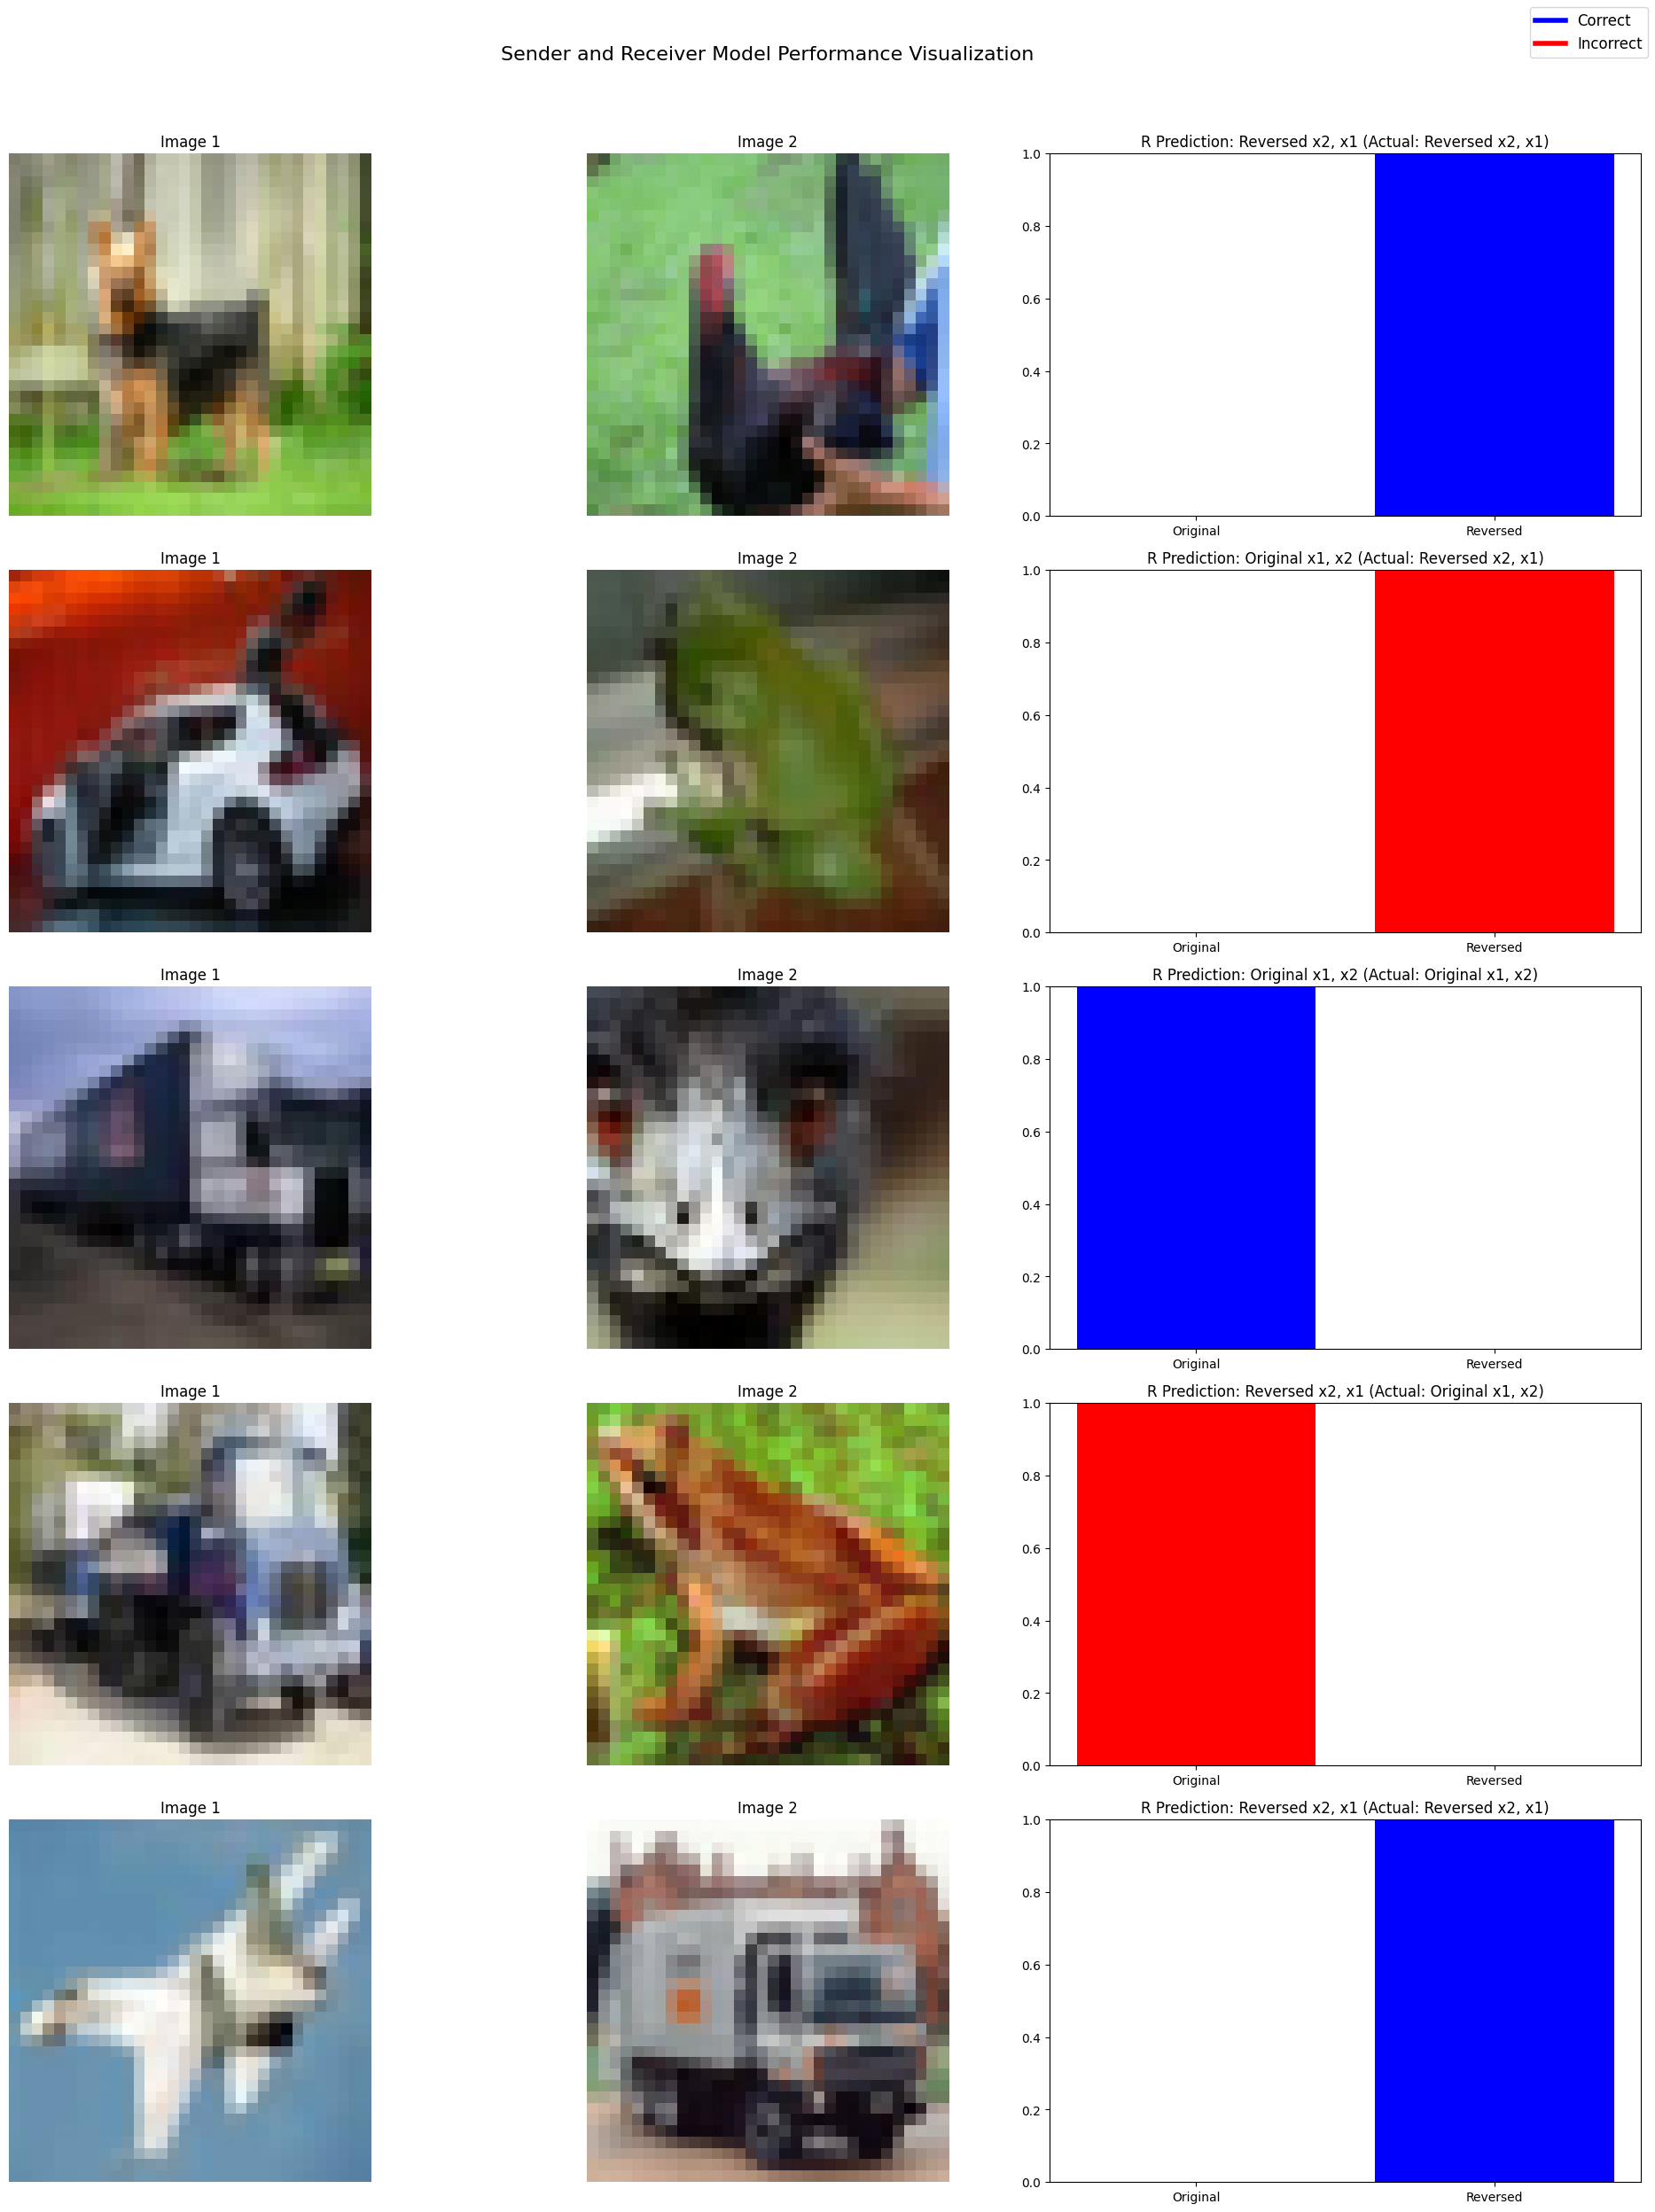

In [138]:
def visualize_model_performance(sender, receiver, p, test_loader, num_samples=5, embedding_dim=64, device=None):
    sender.eval()
    receiver.eval()
    
    # Get some random test images
    dataiter = iter(test_loader)
    fig, axs = plt.subplots(num_samples, 3, figsize=(20, 5*num_samples))
    fig.suptitle("Sender and Receiver Model Performance Visualization", fontsize=16)
    
    for i in range(num_samples):
        x, x1_aug, x2_aug = next(dataiter)
        x, x1_aug, x2_aug = x.to(device), x1_aug.to(device), x2_aug.to(device)
        
        # Sender processes concatenated images
        with torch.no_grad():
            s_output = sender(x)
            b_x = binarize(s_output)
        
            # Map b(x) to learnable embedding
            embedding = torch.where(b_x == 1, 
                                    torch.ones(embedding_dim), 
                                    torch.zeros(embedding_dim))
            
            # Randomly choose order for receiver input
            ber_p = torch.bernoulli(torch.full((x.size(0),), p))
            x_receiver = torch.where(ber_p.unsqueeze(1).unsqueeze(2).unsqueeze(3) == 0,
                                     torch.cat([x1_aug, x2_aug], dim=1),
                                     torch.cat([x2_aug, x1_aug], dim=1))
            
            # Receiver processes
            r_output = receiver(x_receiver, embedding)
            
            # Get receiver's prediction
            predicted = (torch.sigmoid(r_output) > 0.5).float()
        
        # Convert tensors to numpy for visualization
        img1 = x[0, :3].cpu().numpy().transpose(1, 2, 0)
        img2 = x[0, 3:].cpu().numpy().transpose(1, 2, 0)
        
        # Normalize images for display
        img1 = (img1 - img1.min()) / (img1.max() - img1.min())
        img2 = (img2 - img2.min()) / (img2.max() - img2.min())
        
        # Plot original images
        axs[i, 0].imshow(img1)
        axs[i, 0].set_title("Image 1")
        axs[i, 0].axis('off')
        
        axs[i, 1].imshow(img2)
        axs[i, 1].set_title("Image 2")
        axs[i, 1].axis('off')
        
        # Plot receiver's prediction
        actual_order = 'Original x1, x2' if ber_p[0].item() == 0 else 'Reversed x2, x1'
        predicted_order = 'Original x1, x2' if predicted[0].item() == 0 else 'Reversed x2, x1'
        color = 'blue' if ber_p[0].item() == predicted[0].item() else 'red'
        axs[i, 2].bar(['Original', 'Reversed'], [1 - ber_p[0].item(), ber_p[0].item()], color=color)
        axs[i, 2].set_title(f"R Prediction: {predicted_order} (Actual: {actual_order})")
        axs[i, 2].set_ylim(0, 1)
        
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    # Add legend
    fig.legend(handles=[plt.Line2D([0], [0], color='blue', lw=4, label='Correct'),
                        plt.Line2D([0], [0], color='red', lw=4, label='Incorrect')],
               loc='upper right', fontsize='large')
    
    plt.show()

# Visualize model performance
visualize_model_performance(best_sender, best_receiver, BERNOULLI_P, test_loader, num_samples=5, device=device)